In [1]:
import setGPU

import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt

setGPU: Setting GPU to: 0


/home/vuu/anaconda3/envs/tfpy3_exp/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/vuu/anaconda3/envs/tfpy3_exp/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/vuu/anaconda3/envs/tfpy3_exp/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/vuu/anaconda3/envs/tfpy3_exp/lib/python3

### auto encoder experimentations with mnist dataset ####

In [2]:
""" load mnist dataset, normalize and reshape them """
encoding_dim = 32
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [3]:
""" plot model history using this function """
def plot_history(history):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.show()
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()

In [4]:
""" visual model predictions here """
def visualize_predictions(ae, encoder):
    encoded_imgs = encoder.predict(x_test)
    decoded_imgs = ae.predict(x_test)
    print(encoded_imgs.mean())

    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(n):
        #display original
        ax = plt.subplot(2, n, i+1)
        plt.imshow(x_test[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        #display reconstruected
        ax = plt.subplot(2, n, i+1+n)
        plt.imshow(decoded_imgs[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

In [5]:
########## simple auto encoder #################
def two_layer_dense_network():
    input_img = tf.keras.layers.Input(shape=(784,))

    encoded = tf.keras.layers.Dense(encoding_dim, activation='relu')(input_img)
    decoded = tf.keras.layers.Dense(784, activation='sigmoid')(encoded)

    ae = tf.keras.models.Model(input_img, decoded)
    encoder = tf.keras.models.Model(input_img, encoded)

    encoded_input = tf.keras.layers.Input(shape=(encoding_dim,))
    decoder_layer = ae.layers[-1]
    decoder = tf.keras.models.Model(encoded_input, decoder_layer(encoded_input))

    ae.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['acc'])
    
    return ae, encoder

In [6]:
ae_2, encoder_2 = two_layer_dense_network()
ES_callback=tf.keras.callbacks.EarlyStopping(monitor='val_acc', min_delta=0, patience=20)
history = ae_2.fit(x_train, x_train, epochs=500, batch_size=256, shuffle=True, validation_data=(x_test, x_test), callbacks=[ES_callback])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 60000 samples, validate on 10000 samples
Epoch 1/500
60000/60000 [==============================] - 1s 24us/sample - loss: 0.6942 - acc: 0.4077 - val_loss: 0.6941 - val_acc: 0.4081
Epoch 2/500
60000/60000 [==============================] - 1s 20us/sample - loss: 0.6940 - acc: 0.4093 - val_loss: 0.6940 - val_acc: 0.4097
Epoch 3/500
60000/60000 [==============================] - 1s 21us/sample - loss: 0.6938 - acc: 0.4109 - val_loss: 0.6938 - val_acc: 0.4113
Epoch 4/500
60000/60000 [==============================] - 1s 21us/sample - loss: 0.6937 - acc: 0.4125 - val_loss: 0.6936 - val_acc: 0.4128
Epoch 5/500
60000/60000 [==============================] - 1s 21us/sample - loss: 0.6935 - acc: 0.4141 - val_loss: 0.6934 - val_acc: 0.4144
Epoch 6/500
60000/60000 [=============

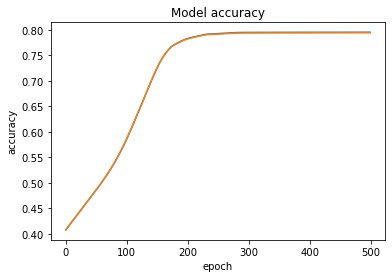

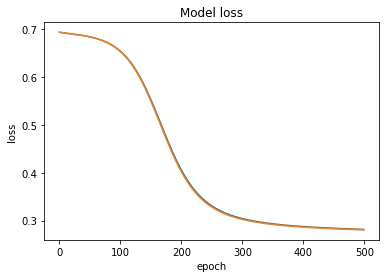

In [8]:
plot_history(history)

2.0940578


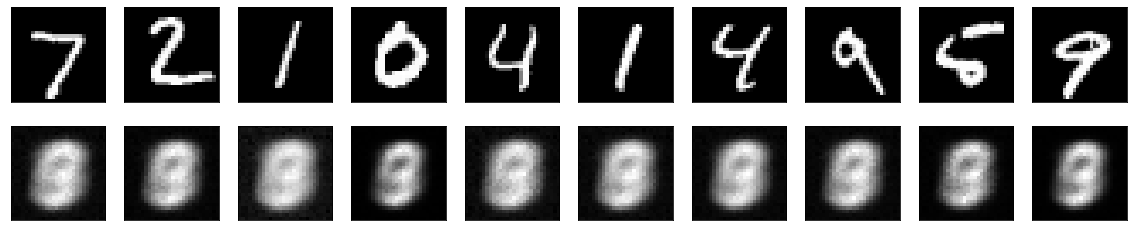

In [9]:
visualize_predictions(ae_2, encoder_2)

In [5]:
##### sparse auto encoder #####
def two_layer_sparse_network():
    input_img = tf.keras.layers.Input(shape=(784,))

    encoded = tf.keras.layers.Dense(encoding_dim, activation='relu', activity_regularizer=tf.keras.regularizers.l1(10e-5))(input_img)
    decoded = tf.keras.layers.Dense(784, activation='sigmoid')(encoded)

    ae = tf.keras.models.Model(input_img, decoded)
    encoder = tf.keras.models.Model(input_img, encoded)

    encoded_input = tf.keras.layers.Input(shape=(encoding_dim,))
    decoder_layer = ae.layers[-1]
    decoder = tf.keras.models.Model(encoded_input, decoder_layer(encoded_input))

    ae.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['acc'])
    
    return ae, encoder

In [6]:
ae_sparse, encoder_sparse = two_layer_sparse_network()
ES_callback=tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=20)
history = ae_sparse.fit(x_train, x_train, epochs=500, batch_size=256, shuffle=True, validation_data=(x_test, x_test), callbacks=[ES_callback])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 60000 samples, validate on 10000 samples
Epoch 1/500
60000/60000 [==============================] - 2s 26us/sample - loss: 0.6937 - acc: 0.4197 - val_loss: 0.6936 - val_acc: 0.4199
Epoch 2/500
60000/60000 [==============================] - 1s 22us/sample - loss: 0.6935 - acc: 0.4213 - val_loss: 0.6934 - val_acc: 0.4215
Epoch 3/500
60000/60000 [==============================] - 1s 21us/sample - loss: 0.6933 - acc: 0.4228 - val_loss: 0.6932 - val_acc: 0.4230
Epoch 4/500
60000/60000 [==============================] - 1s 22us/sample - loss: 0.6932 - acc: 0.4244 - val_loss: 0.6931 - val_acc: 0.4246
Epoch 5/500
60000/60000 [==============================] - 1s 22us/sample - loss: 0.6930 - acc: 0.4260 - val_loss: 0.6929 - val_acc: 0.4262
Epoch 6/500
60000/60000 [=============

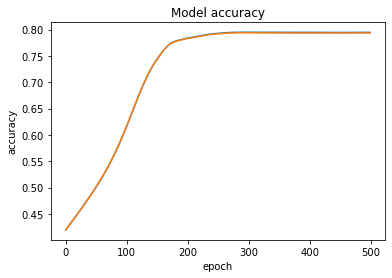

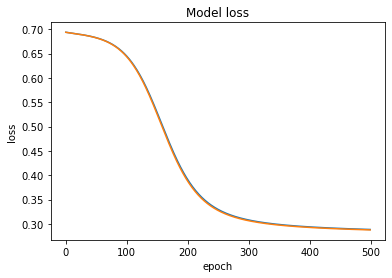

In [7]:
plot_history(history)

2.3421967


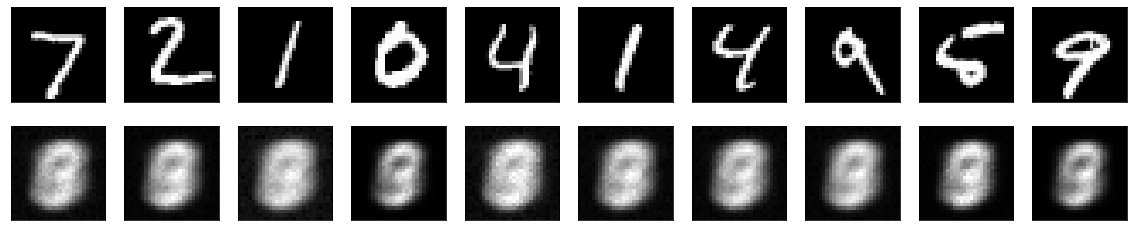

In [8]:
visualize_predictions(ae_sparse, encoder_sparse)

In [9]:
##### Deep dense auto encoder #####
def three_layer_dense_net():
    input_img = tf.keras.layers.Input(shape=(784,))
    encoded = tf.keras.layers.Dense(256, activation='relu')(input_img)
    encoded = tf.keras.layers.Dense(128, activation='relu')(encoded)
    encoded = tf.keras.layers.Dense(64, activation='relu')(encoded)
    encoded = tf.keras.layers.Dense(32, activation='relu')(encoded)
    encoder = tf.keras.models.Model(input_img, encoded)

    decoded = tf.keras.layers.Dense(64, activation='relu')(encoded)
    decoded = tf.keras.layers.Dense(128, activation='relu')(decoded)
    decoded = tf.keras.layers.Dense(256, activation='relu')(decoded)
    decoded = tf.keras.layers.Dense(784, activation='sigmoid')(decoded)

    ae = tf.keras.models.Model(input_img, decoded)

    encoder_input = tf.keras.layers.Input(shape=(encoding_dim, ))
    decoder_layer = ae.layers[0]
    decoder = tf.keras.models.Model(encoder_input, decoder_layer(encoder_input))

    ae.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['acc'])
    
    return ae, encoder

In [15]:
ae_3, encoder_3 = three_layer_dense_net()
ES_callback = tf.keras.callbacks.EarlyStopping(monitor='val_acc', min_delta=0, patience=20)
history = ae_3.fit(x_train, x_train, epochs=500, batch_size=256, shuffle=True, validation_data=(x_test, x_test), callbacks=[ES_callback])

Train on 60000 samples, validate on 10000 samples
Epoch 1/500
60000/60000 [==============================] - 2s 28us/sample - loss: 0.6931 - acc: 0.4145 - val_loss: 0.6931 - val_acc: 0.4155
Epoch 2/500
60000/60000 [==============================] - 2s 27us/sample - loss: 0.6930 - acc: 0.4185 - val_loss: 0.6930 - val_acc: 0.4195
Epoch 3/500
60000/60000 [==============================] - 2s 27us/sample - loss: 0.6929 - acc: 0.4226 - val_loss: 0.6929 - val_acc: 0.4234
Epoch 4/500
60000/60000 [==============================] - 2s 27us/sample - loss: 0.6929 - acc: 0.4266 - val_loss: 0.6928 - val_acc: 0.4274
Epoch 5/500
60000/60000 [==============================] - 2s 27us/sample - loss: 0.6928 - acc: 0.4306 - val_loss: 0.6928 - val_acc: 0.4313
Epoch 6/500
60000/60000 [==============================] - 2s 26us/sample - loss: 0.6927 - acc: 0.4346 - val_loss: 0.6927 - val_acc: 0.4353
Epoch 7/500
60000/60000 [==============================] - 2s 27us/sample - loss: 0.6927 - acc: 0.4386 - val_l

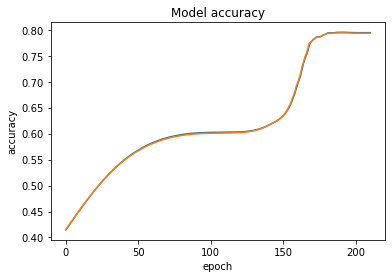

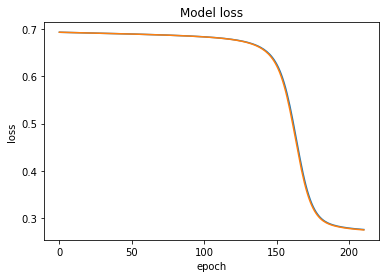

In [16]:
plot_history(history)

1.9890201


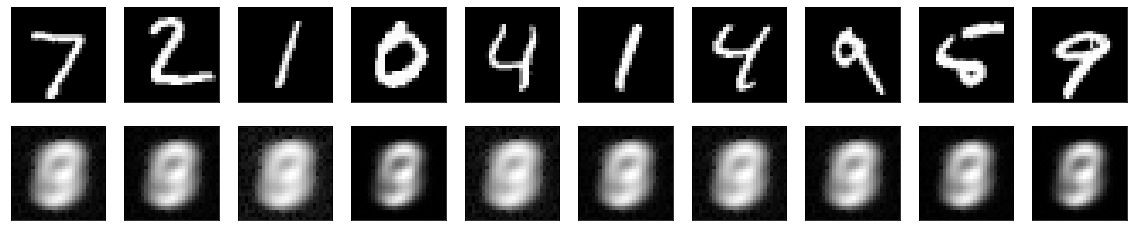

In [19]:
visualize_predictions(ae_3, encoder_3)

In [6]:
img_size = x_train.shape[1]
input_shape = (img_size, img_size, 1)
batch_size = 128
kernel_size = 3
filters = 16
latent_dim = 2
epochs = 3

In [7]:
#reparameterization trick
#instead of sampling from Q(z/x), sample eps = N(0, I)
#then z = z_mean+sqrt(var)*eps
def sampling(args):
    z_mean, z_log_var = args
    batch = tf.keras.backend.shape(z_mean)[0]
    dim = tf.keras.backend.int_shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch,dim))
    return z_mean + tf.keras.backend.exp(0.5*z_log_var) * epsilon

In [8]:
#VAE model = encoder + decoder
#build encoder model
inputs = tf.keras.layers.Input(shape=input_shape, name='encoder_input')
x = inputs
for i in range(2):
    filters *=2
    x = tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation='relu', strides=2, padding='same')(x)
    
shape = tf.keras.backend.int_shape(x)

x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(16, activation='relu')(x)
z_mean = tf.keras.layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = tf.keras.layers.Dense(latent_dim, name='z_log_var')(x)
z = tf.keras.layers.Lambda(sampling, output_shape=(latent_dim, ), name='z')([z_mean, z_log_var])

encoder = tf.keras.models.Model(inputs, [z_mean, z_log_var, z], name='encoder')
#encoder.summary()
#plot_model(encoder, to_file='../model/vae_mnist/vae_cnn_encoder.png', show_shapes=True)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [9]:
#build decoder model
latent_inputs = tf.keras.layers.Input(shape=(latent_dim, ), name='z_sampling')
x = tf.keras.layers.Dense(shape[1]*shape[2]*shape[3], activation='relu')(latent_inputs)
x = tf.keras.layers.Reshape((shape[1], shape[2], shape[3]))(x)

for i in range(2):
    x = tf.keras.layers.Conv2DTranspose(filters=filters, kernel_size=kernel_size, activation='relu', strides=2, padding='same')(x)
    filters //= 2
    
outputs = tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=kernel_size, activation='sigmoid', padding='same', name='decoder_output')(x)

decoder = tf.keras.models.Model(latent_inputs, outputs, name='decoder')
#decoder.summary()
#plot_model(decoder, to_file='../model/vae_mnist/vae_cnn_decoder.png', show_shapes=True)

outputs = decoder(encoder(inputs)[2])
vae = tf.keras.models.Model(inputs, outputs, name='vae')

In [10]:
models = (encoder, decoder)
data = (x_test, y_test)

val_mse = True

if val_mse:
    reconstruction_loss = tf.keras.losses.mse(tf.keras.backend.flatten(inputs), tf.keras.backend.flatten(outputs))
else:
    reconstruction_loss = tf.keras.losses.binary_crossentropy(tf.keras.backend.flatten(inputs), tf.keras.backend.flatten())
    
reconstruction_loss *= img_size*img_size
kl_loss = 1 + z_log_var - tf.keras.backend.square(z_mean) - tf.keras.backend.exp(z_log_var)
kl_loss = tf.keras.backend.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = tf.keras.backend.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='rmsprop')
#vae.summary()
#plot_model(vae, to_file='../model/vae_mnist/vae_cnn.png', show_shapes=True)

vae.fit(x_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, None))

ValueError: Error when checking input: expected encoder_input to have 4 dimensions, but got array with shape (60000, 784)